# Copy-Move Forgery Detection using UNet3Plus

This notebook trains a UNet3Plus model to detect copy-move forgeries in scientific images.
- Converts all images to RGB 256x256 (grayscale extended to 3 channels)
- Uses OR operation to merge multiple mask instances into single-channel masks
- Uses UNet3Plus architecture
- Outputs copy-move masks for forged regions


In [1]:
# Imports and Setup
import os
import random
import glob
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from time import time
from PIL import Image
import math
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True


In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'CUDA Version: {torch.version.cuda}')


Using device: cuda
GPU: NVIDIA GeForce RTX 5060 Ti
CUDA Version: 13.0


In [4]:
# Configuration
DATA_ROOT = './data'
TRAIN_IMAGES_AUTH = os.path.join(DATA_ROOT, 'train_images/authentic')
TRAIN_IMAGES_FORG = os.path.join(DATA_ROOT, 'train_images/forged')
TRAIN_MASKS_DIR = os.path.join(DATA_ROOT, 'train_masks')
SUPP_IMAGES_DIR = os.path.join(DATA_ROOT, 'supplemental_images')
SUPP_MASKS_DIR = os.path.join(DATA_ROOT, 'supplemental_masks')
TEST_IMAGES_DIR = os.path.join(DATA_ROOT, 'test_images')

# Model save path
MODEL_SAVE_PATH = './saved_models'
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)




In [5]:
# ============================================================================
# MODEL AND TRAINING CONFIGURATION
# ============================================================================
# Modify these parameters to control model architecture, loss, and training

# ===== MODEL ARCHITECTURE PARAMETERS =====
MODEL_CONFIG = {
    'channels': [3, 64, 128, 256, 512],  # Encoder channels: [input, layer1, layer2, ...]
    'skip_ch': 32,                       # Decoder skip connection channels
    'num_block': 2,                      # Number of conv blocks per encoder layer (1 or 2)
    'num_classes': 1,                    # Output classes (1 for binary segmentation)
    'dropout': 0.2,                      # Dropout rate in decoder
    'aux_losses': 0,                     # Number of auxiliary losses (0 = disabled)
    'use_cgm': False,                    # Use Classification-Guided Module (CGM)
    'fast_up': True,                     # Fast upsampling in decoder
    'transpose_final': False,            # Use transpose conv for final layer
    'bottom_dec_ch': 512,               # Bottom decoder channels
}

# ===== LOSS FUNCTION PARAMETERS =====
LOSS_CONFIG = {
    'tversky_weight': 0.7,               # Weight for Tversky loss in combined loss
    'bce_weight': 0.3,                   # Weight for BCE loss in combined loss
    'alpha': 0.5,                        # Tversky alpha (FP penalty) - higher = more FP penalty
    'beta': 0.5,                         # Tversky beta (FN penalty) - higher = more FN penalty
    'smooth': 1                          # Smoothing term for Tversky loss
}

# ===== TRAINING PARAMETERS =====
TRAIN_CONFIG = {
    'batch_size': 16,                    # Batch size for training
    'learning_rate': 0.0001,             # Learning rate for optimizer
    'epochs': 20,                        # Total number of training epochs
    'val_split': 0.15,                   # Validation split ratio (0.15 = 15%)
    'early_stopping_patience': 10        # Early stopping patience (epochs)
}

# ===== DATASET PARAMETERS =====
DATASET_CONFIG = {
    'image_size': 256,                    # Input image size (256x256)
    'skip_authentic_epochs': 10,          # Number of epochs to skip authentic images (0-4)
    'num_workers': 0,                    # DataLoader num_workers (0 = main process, 4-8 recommended)
    'pin_memory': True,                  # Pin memory for faster GPU transfer
    'prefetch_factor': 2                 # Prefetch factor for DataLoader
}

# ===== OPTIMIZER PARAMETERS =====
OPTIMIZER_CONFIG = {
    'optimizer': 'Adam',                 # Optimizer type ('Adam', 'SGD', etc.)
    'weight_decay': 0.0,                 # Weight decay (L2 regularization)
    'betas': (0.9, 0.999)                # Adam betas (if using Adam)
}

# ============================================================================
# Extract parameters for backward compatibility
# ============================================================================
IMAGE_SIZE = DATASET_CONFIG['image_size']
BATCH_SIZE = TRAIN_CONFIG['batch_size']
LEARNING_RATE = TRAIN_CONFIG['learning_rate']
EPOCHS = TRAIN_CONFIG['epochs']
VAL_SPLIT = TRAIN_CONFIG['val_split']

# Print configuration
print("="*70)
print("CONFIGURATION SUMMARY")
print("="*70)
print(f"Model: channels={MODEL_CONFIG['channels']}, skip_ch={MODEL_CONFIG['skip_ch']}, num_block={MODEL_CONFIG['num_block']}")
print(f"Loss: Tversky({LOSS_CONFIG['alpha']}, {LOSS_CONFIG['beta']}) * {LOSS_CONFIG['tversky_weight']} + BCE * {LOSS_CONFIG['bce_weight']}")
print(f"Training: batch_size={TRAIN_CONFIG['batch_size']}, lr={TRAIN_CONFIG['learning_rate']}, epochs={TRAIN_CONFIG['epochs']}")
print(f"Dataset: image_size={DATASET_CONFIG['image_size']}, skip_authentic_epochs={DATASET_CONFIG['skip_authentic_epochs']}")
print("="*70)


CONFIGURATION SUMMARY
Model: channels=[3, 64, 128, 256, 512], skip_ch=32, num_block=2
Loss: Tversky(0.5, 0.5) * 0.7 + BCE * 0.3
Training: batch_size=16, lr=0.0001, epochs=20
Dataset: image_size=256, skip_authentic_epochs=10


In [6]:
# Custom Dataset Class
class ForgeryDataset(Dataset):
    def __init__(self, image_paths, mask_paths=None, image_size=None, is_train=True, skip_authentic=False):
        # Use config default if not provided
        if image_size is None:
            image_size = DATASET_CONFIG['image_size']
        """
        Args:
            image_paths: list of image file paths
            mask_paths: dict mapping image stem to mask path (None for authentic images)
            image_size: target image size (256x256)
            is_train: whether this is training data (for augmentation)
            skip_authentic: if True, filter out authentic images (only use forged images)
        """
        # Filter out authentic images if skip_authentic is True
        if skip_authentic:
            self.image_paths = [path for path in image_paths if 'authentic' not in path.lower()]
            print(f"Dataset: Skipping authentic images. Filtered to {len(self.image_paths)} forged images (from {len(image_paths)} total)")
        else:
            self.image_paths = image_paths
        
        self.mask_paths = mask_paths if mask_paths else {}
        self.image_size = image_size
        self.is_train = is_train
        self.skip_authentic = skip_authentic
        
    def __len__(self):
        return len(self.image_paths)
    
    def load_mask_npy(self, mask_path):
        """
        Load .npy mask and merge multiple instances using OR operation.
        Returns single-channel binary mask in original size (not resized).
        """
        try:
            mask_data = np.load(mask_path, allow_pickle=True)
            
            # Handle different mask formats
            if isinstance(mask_data, (list, tuple)):
                # Multiple masks in list/tuple - OR them together
                if len(mask_data) == 0:
                    # Return empty mask - we'll determine size from first valid mask
                    return None
                
                # Collect all mask arrays
                arrs = []
                for item in mask_data:
                    item = np.asarray(item)
                    if item.ndim == 2:
                        arrs.append((item > 0).astype(np.uint8))
                    elif item.ndim == 3:
                        arrs.append((item.sum(axis=0) > 0).astype(np.uint8))
                
                if len(arrs) == 0:
                    return None
                
                # Stack and OR them
                stacked = np.stack(arrs, axis=0)
                merged_mask = (stacked.sum(axis=0) > 0).astype(np.uint8)
                
            elif isinstance(mask_data, dict):
                # Dictionary format - extract masks
                key = 'masks' if 'masks' in mask_data else list(mask_data.keys())[0]
                mask_array = np.asarray(mask_data[key])
                if mask_array.ndim == 3:
                    merged_mask = (mask_array.sum(axis=0) > 0).astype(np.uint8)
                else:
                    merged_mask = (mask_array > 0).astype(np.uint8)
            else:
                # NumPy array
                mask_array = np.asarray(mask_data)
                if mask_array.ndim == 2:
                    merged_mask = (mask_array > 0).astype(np.uint8)
                elif mask_array.ndim == 3:
                    # (N, H, W) - OR operation across instances
                    merged_mask = (mask_array.sum(axis=0) > 0).astype(np.uint8)
                else:
                    return None
            
            return merged_mask
        except Exception as e:
            print(f"Error loading mask {mask_path}: {e}")
            import traceback
            traceback.print_exc()
            return None
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img_stem = Path(img_path).stem
        
        # Load image and convert to RGB
        # .convert('RGB') automatically handles grayscale -> RGB conversion by duplicating channels
        image = Image.open(img_path).convert('RGB')
        
        # Resize to 256x256
        image = image.resize((self.image_size, self.image_size), Image.BILINEAR)
        
        # Convert to tensor and normalize to [0, 1]
        # After .convert('RGB'), this will always be (3, H, W)
        image_tensor = TF.to_tensor(image)  # (3, H, W) - RGB
        
        # Safety check: ensure we always have 3 channels (should always be true after .convert('RGB'))
        if image_tensor.shape[0] == 1:
            image_tensor = image_tensor.repeat(3, 1, 1)  # (3, H, W)
        
        # Load mask (if exists and image is not authentic)
        # Check if image is from authentic folder - authentic images should never have masks
        is_authentic = 'authentic' in img_path.lower()
        
        if is_authentic:
            # Authentic image - always create zero mask (even if mask exists in dictionary due to name collision)
            mask_tensor = torch.zeros((1, self.image_size, self.image_size), dtype=torch.float32)
        else:
            # Forged image - try to load mask
            mask_path = self.mask_paths.get(img_stem)
            if mask_path and os.path.exists(mask_path):
                mask = self.load_mask_npy(mask_path)
                if mask is not None and mask.size > 0:
                    # Ensure mask is in [0, 255] range for PIL
                    if mask.max() <= 1:
                        mask = (mask * 255).astype(np.uint8)
                    
                    # Resize mask to match image size
                    mask_pil = Image.fromarray(mask, mode='L')
                    mask_pil = mask_pil.resize((self.image_size, self.image_size), Image.NEAREST)
                    # Convert to numpy and then to tensor
                    mask_np = np.array(mask_pil, dtype=np.float32) / 255.0  # Normalize to [0, 1]
                    mask_tensor = torch.from_numpy(mask_np).unsqueeze(0)  # (1, H, W)
                else:
                    # Failed to load mask - create zero mask
                    mask_tensor = torch.zeros((1, self.image_size, self.image_size), dtype=torch.float32)
            else:
                # No mask found - create zero mask
                mask_tensor = torch.zeros((1, self.image_size, self.image_size), dtype=torch.float32)
        
        # Binarize mask (ensure binary)
        mask_tensor = (mask_tensor > 0.5).float()
        
        return {
            'image': image_tensor,
            'mask': mask_tensor,
            'path': img_path
        }


In [7]:
# UNet3Plus Architecture
from typing import List

def weight_init(m):
    """
    Initialize weights for neural network modules.
    Uses Kaiming normal for Conv2d and normal for BatchNorm2d.
    """
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


num_block = MODEL_CONFIG['num_block']
skip_ch = MODEL_CONFIG['skip_ch']
bottom_dec_ch = MODEL_CONFIG['bottom_dec_ch']
dropout = MODEL_CONFIG['dropout']


def u3pblock(in_ch, out_ch, num_block=num_block, kernel_size=3, padding=1, down_sample=False):
    m = []
    if down_sample:
        m.append(nn.MaxPool2d(kernel_size=2))
    for _ in range(num_block):
        m += [nn.Conv2d(in_ch, out_ch, kernel_size, bias=False, padding=padding),
              nn.BatchNorm2d(out_ch),
              nn.ReLU(inplace=True)]
        in_ch = out_ch
    return nn.Sequential(*m)

def en2dec_layer(in_ch, out_ch, scale):
    m = [nn.Identity()] if scale == 1 else [nn.MaxPool2d(scale, scale, ceil_mode=True)]
    m.append(u3pblock(in_ch, out_ch, num_block=num_block))
    return nn.Sequential(*m)

def dec2dec_layer(in_ch, out_ch, scale, fast_up=True):
    up = [nn.Upsample(scale_factor=scale, mode='bilinear', align_corners=True) if scale != 1 else nn.Identity()]
    m = [u3pblock(in_ch, out_ch, num_block=num_block)]
    if fast_up:
        m = m + up
    else:
        m = up + m  # used in paper
    return nn.Sequential(*m)

        
class FullScaleSkipConnect(nn.Module):
    def __init__(self, 
                 en_channels,   # encoder out channels, high to low
                 en_scales,
                 num_dec,       # number of decoder out
                 skip_ch=skip_ch, 
                 dec_scales=None,
                 bottom_dec_ch=bottom_dec_ch,
                 dropout=dropout,
                 fast_up=True,):

        super().__init__()
        concat_ch = skip_ch * (len(en_channels) + num_dec)

        # encoder maps to decoder maps connectionsf
        self.en2dec_layers = nn.ModuleList()
        for ch, scale in zip(en_channels, en_scales):
            self.en2dec_layers.append(en2dec_layer(ch, skip_ch, scale))
        
        # decoder maps to decoder maps connections
        self.dec2dec_layers = nn.ModuleList()
        if dec_scales is None:
            dec_scales = []
            for ii in reversed(range(num_dec)):
                dec_scales.append(2 ** (ii + 1))
        for ii, scale in enumerate(dec_scales):
            dec_ch = bottom_dec_ch if ii == 0 else concat_ch
            self.dec2dec_layers.append(dec2dec_layer(dec_ch, skip_ch, scale, fast_up=fast_up))

        self.droupout = nn.Dropout(dropout)
        self.fuse_layer = u3pblock(concat_ch, concat_ch, 1)

    def forward(self, en_maps, dec_maps=None):
        out = []
        for en_map, layer in zip(en_maps, self.en2dec_layers):
            out.append(layer(en_map))
        if dec_maps is not None and len(dec_maps) > 0:
            for dec_map, layer in zip(dec_maps, self.dec2dec_layers):
                out.append(layer(dec_map))
        return self.fuse_layer(self.droupout(torch.cat(out, 1)))


class U3PEncoderDefault(nn.Module):
    def __init__(self, channels = [3, 64, 128, 256, 512], num_block=num_block):
        super().__init__()
        self.layers = nn.ModuleList()
        self.downsample_list = nn.Module()
        for ii, (ch_in, ch_out) in enumerate(zip(channels[:-1], channels[1:])):
            self.layers.append(u3pblock(ch_in, ch_out, num_block, down_sample= ii > 0))
        self.channels = channels
        self.apply(weight_init)
        
    def forward(self, x):
        encoder_out = []
        for layer in self.layers:
            x = layer(x)
            encoder_out.append(x)
        return encoder_out


class U3PDecoder(nn.Module):
    def __init__(self, en_channels = [64, 128, 256, 512], skip_ch=skip_ch, dropout=dropout, fast_up=True):
        super().__init__()
        self.decoders = nn.ModuleDict()
        en_channels = en_channels[::-1]
        num_en_ch = len(en_channels)
        for ii in range(num_en_ch):
            if ii == 0:
                # first decoding output is identity mapping of last encoder map
                self.decoders['decoder1'] = nn.Identity()
                continue

            self.decoders[f'decoder{ii+1}'] = FullScaleSkipConnect(
                                                en_channels[ii:], 
                                                en_scales=2 ** np.arange(0, num_en_ch-ii),
                                                num_dec=ii, 
                                                skip_ch=skip_ch, 
                                                bottom_dec_ch=en_channels[0],
                                                dropout=dropout,
                                                fast_up=fast_up
                                            )

    def forward(self, enc_map_list:List[torch.Tensor]):
        dec_map_list = []
        enc_map_list = enc_map_list[::-1]
        for ii, layer_key in enumerate(self.decoders):
            layer = self.decoders[layer_key]
            if ii == 0:
                dec_map_list.append(layer(enc_map_list[0]))
                continue
            dec_map_list.append(layer(enc_map_list[ii: ], dec_map_list))
        return dec_map_list


class UNet3Plus(nn.Module):

    def __init__(self, 
                 num_classes=1,
                 skip_ch=32,
                 aux_losses=0,  # Set to 0 to simplify output during training
                 encoder: U3PEncoderDefault = None,
                 channels=[3, 64, 128, 256, 512],
                 dropout=0.3,
                 transpose_final=False,
                 use_cgm=False,  # Disable CGM for simpler output
                 fast_up=True):
        super().__init__()

        self.encoder = U3PEncoderDefault(channels) if encoder is None else encoder
        channels = self.encoder.channels
        num_decoders = len(channels) - 1
        decoder_ch = skip_ch * num_decoders

        self.decoder = U3PDecoder(self.encoder.channels[1:], skip_ch=skip_ch, dropout=dropout, fast_up=fast_up)
        self.decoder.apply(weight_init)
        
        self.cls = None  # Disabled for simplicity
        
        if transpose_final:
            self.head = nn.Sequential(
                nn.ConvTranspose2d(decoder_ch, num_classes, kernel_size=4, stride = 2, padding=1, bias=False),
            )
        else:
            self.head = nn.Conv2d(decoder_ch, num_classes, 3, padding=1)
        self.head.apply(weight_init)

        self.aux_head = None  # Disabled for simplicity

    def forward(self, x): 
        _, _, h, w = x.shape
        de_out = self.decoder(self.encoder(x))

        pred = self.resize(self.head(de_out[-1]), h, w)
        pred = torch.sigmoid(pred)  # Apply sigmoid for binary segmentation
        
        return pred
    
    def resize(self, x, h, w) -> torch.Tensor:
        _, _, xh, xw = x.shape
        if xh != h or xw != w:
            x = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=True)
        return x


In [8]:
# Loss Functions and Metrics
def tversky_loss(inputs, targets, alpha=0.7, beta=0.3, smooth=1):
    """
    Tversky Loss for binary segmentation
    alpha: weight for false positives (default 0.7)
    beta: weight for false negatives (default 0.3)
    Higher alpha punishes false positives more, higher beta punishes false negatives more
    For fraud/lesions/anomalies, we want to punish FN more (beta < alpha)
    """
    inputs = inputs.view(-1)
    targets = targets.view(-1)
    
    # True Positives, False Positives, False Negatives
    tp = (inputs * targets).sum()
    fp = (inputs * (1 - targets)).sum()
    fn = ((1 - inputs) * targets).sum()
    
    # Tversky Index
    tversky = (tp + smooth) / (tp + alpha * fp + beta * fn + smooth)
    
    return 1 - tversky

def bce_loss(inputs, targets):
    """Binary Cross-Entropy Loss"""
    inputs = inputs.view(-1)
    targets = targets.view(-1)
    return F.binary_cross_entropy(inputs, targets)

def combined_loss(inputs, targets, tversky_weight=0.7, bce_weight=0.3, alpha=0.7, beta=0.3):
    """
    Combined Tversky + BCE Loss
    tversky_weight: weight for Tversky loss (default 0.7)
    bce_weight: weight for BCE loss (default 0.3)
    alpha, beta: Tversky parameters (alpha=0.7, beta=0.3 punishes FN more)
    """
    tversky = tversky_loss(inputs, targets, alpha=alpha, beta=beta)
    bce = bce_loss(inputs, targets)
    return tversky_weight * tversky + bce_weight * bce

def dice_coefficient_torch(predicted, target, smooth=1):
    """Dice coefficient metric (torch version for training loop)"""
    predicted = predicted.view(-1)
    target = target.view(-1)
    intersection = (predicted * target).sum()
    coefficient = (2 * intersection + smooth) / (predicted.sum() + target.sum() + smooth)
    return coefficient.item()

def dice_coefficient(predicted, target, smooth=1):
    """Dice coefficient metric (for evaluation, numpy version)"""
    product = np.multiply(predicted, target)
    intersection = np.sum(product)
    coefficient = (2 * intersection + smooth) / (np.sum(predicted) + np.sum(target) + smooth)
    return coefficient

def iou_score(output, target, smooth=1e-6):
    """IoU (Intersection over Union) metric"""
    output = (output > 0.5).float()
    intersection = (output * target).sum()
    union = output.sum() + target.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()


In [9]:
# Prepare Dataset
print("Loading dataset...")

# Get all image paths
authentic_images = glob.glob(os.path.join(TRAIN_IMAGES_AUTH, '*.png'))
forged_images = glob.glob(os.path.join(TRAIN_IMAGES_FORG, '*.png'))

print(f"Authentic images: {len(authentic_images)}")
print(f"Forged images: {len(forged_images)}")

# Load mask paths
train_masks = {}
for mask_file in glob.glob(os.path.join(TRAIN_MASKS_DIR, '*.npy')):
    stem = Path(mask_file).stem
    train_masks[stem] = mask_file

print(f"Train masks: {len(train_masks)}")

# Combine all training images
all_train_images = forged_images + authentic_images
all_train_masks = train_masks

# Shuffle
random.shuffle(all_train_images)

print(f"Total training images: {len(all_train_images)}")


Loading dataset...
Authentic images: 2377
Forged images: 2751
Train masks: 2751
Total training images: 5128


In [10]:
# Helper function to create overlay image (extracted from display_image_with_mask)
def create_overlay_image(image, mask, alpha=0.5):
    """
    Create an overlay image by blending image and mask.
    Same logic as used in display_image_with_mask.
    
    Args:
        image: numpy array of shape (H, W) or (H, W, 3) - image in [0, 1]
        mask: numpy array of shape (H, W) - binary mask in [0, 1]
        alpha: transparency of the mask overlay
    
    Returns:
        overlay: numpy array of shape (H, W, 3) - blended overlay image
    """
    # Convert to RGB if needed
    if image.ndim == 2:
        img_rgb = np.stack([image, image, image], axis=-1)  # (H, W, 3)
    else:
        img_rgb = image
    
    # Create colored mask (red overlay)
    mask_colored = np.zeros_like(img_rgb)
    mask_colored[:, :, 0] = mask  # Red channel
    
    # Blend image and mask
    overlay = img_rgb * (1 - alpha * mask[:, :, np.newaxis]) + mask_colored * (alpha * mask[:, :, np.newaxis])
    overlay = np.clip(overlay, 0, 1)
    
    return overlay

# Helper function to display sequence: original, GT mask, predicted mask, overlay
def display_prediction_sequence(image, gt_mask, pred_mask, title="Prediction Sequence", alpha=0.5, figsize=(16, 4)):
    """
    Display sequence: original image, GT mask, predicted mask, overlay.
    
    Args:
        image: numpy array of shape (H, W), (1, H, W), or (3, H, W) - grayscale or RGB image in [0, 1]
        gt_mask: numpy array of shape (H, W) or (1, H, W) - ground truth binary mask in [0, 1]
        pred_mask: numpy array of shape (H, W) or (1, H, W) - predicted binary mask in [0, 1]
        title: title for the figure
        alpha: transparency of the mask overlay
        figsize: figure size
    """
    # Convert to numpy if tensor
    if torch.is_tensor(image):
        image = image.cpu().numpy()
    if torch.is_tensor(gt_mask):
        gt_mask = gt_mask.cpu().numpy()
    if torch.is_tensor(pred_mask):
        pred_mask = pred_mask.cpu().numpy()
    
    # Handle different image formats
    if image.ndim == 3:
        if image.shape[0] == 1:
            image = image.squeeze(0)
        elif image.shape[0] == 3:
            image = image.transpose(1, 2, 0) # (C, H, W) -> (H, W, C)
    
    # Handle mask formats
    if gt_mask.ndim == 3:
        gt_mask = gt_mask.squeeze(0)
    if pred_mask.ndim == 3:
        pred_mask = pred_mask.squeeze(0)
    
    # Ensure values are in [0, 1]
    image = np.clip(image, 0, 1)
    gt_mask = np.clip(gt_mask, 0, 1)
    pred_mask = np.clip(pred_mask, 0, 1)
    
    fig, axes = plt.subplots(1, 4, figsize=figsize)
    
    # 1. Original image
    if image.ndim == 2:
        axes[0].imshow(image, cmap='gray')
    else:
        axes[0].imshow(image)
    axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    # 2. GT mask
    axes[1].imshow(gt_mask, cmap='hot', vmin=0, vmax=1)
    axes[1].set_title('GT Mask', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    # 3. Predicted mask
    axes[2].imshow(pred_mask, cmap='hot', vmin=0, vmax=1)
    axes[2].set_title('Predicted Mask', fontsize=12, fontweight='bold')
    axes[2].axis('off')
    
    # 4. Overlay: use create_overlay_image helper (same logic as display_image_with_mask)
    overlay = create_overlay_image(image, pred_mask, alpha=alpha)
    
    axes[3].imshow(overlay)
    axes[3].set_title('Overlay (Red = Predicted)', fontsize=12, fontweight='bold')
    axes[3].axis('off')
    
    plt.suptitle(title, fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    return fig


In [11]:
# Create dataset and split into train/val
# Start with skip_authentic=True for first 5 epochs
full_dataset = ForgeryDataset(
    image_paths=all_train_images,
    mask_paths=all_train_masks,
    image_size=IMAGE_SIZE,
    is_train=True,
    skip_authentic=True  # Skip authentic images for first 5 epochs
)

# Split dataset
val_size = int(len(full_dataset) * VAL_SPLIT)
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create validation dataset with is_train=False
val_dataset.dataset.is_train = False

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)


Dataset: Skipping authentic images. Filtered to 2751 forged images (from 5128 total)
Train samples: 2339
Validation samples: 412


In [12]:
# Debug: Check mask values for authentic vs forged images
print("="*70)
print("DEBUGGING MASK VALUES")
print("="*70)

# Check a few batches to see what's happening
authentic_samples = []
forged_samples = []

for batch_idx, batch in enumerate(train_loader):
    if batch_idx >= 5:  # Check first 5 batches
        break
    
    masks = batch['mask']  # (B, 1, H, W)
    paths = batch['path']
    
    for i in range(masks.size(0)):
        img_path = paths[i]
        mask = masks[i]  # (1, H, W)
        mask_sum = mask.sum().item()
        mask_min = mask.min().item()
        mask_max = mask.max().item()
        mask_unique = torch.unique(mask).tolist()
        
        # Check if this is an authentic image (no mask file should exist)
        img_stem = Path(img_path).stem
        is_authentic_folder = 'authentic' in img_path
        
        if is_authentic_folder:
            authentic_samples.append({
                'path': img_path,
                'mask_sum': mask_sum,
                'mask_min': mask_min,
                'mask_max': mask_max,
                'mask_unique': mask_unique[:10]  # First 10 unique values
            })
        else:
            forged_samples.append({
                'path': img_path,
                'mask_sum': mask_sum,
                'mask_min': mask_min,
                'mask_max': mask_max,
                'mask_unique': mask_unique[:10]
            })
        
        if len(authentic_samples) >= 3 and len(forged_samples) >= 3:
            break
    
    if len(authentic_samples) >= 3 and len(forged_samples) >= 3:
        break

print(f"\nFound {len(authentic_samples)} authentic samples and {len(forged_samples)} forged samples")
print("\nAUTHENTIC SAMPLES:")
for i, sample in enumerate(authentic_samples[:3], 1):
    print(f"  Sample {i}: {Path(sample['path']).name}")
    print(f"    Mask sum: {sample['mask_sum']:.6f}")
    print(f"    Mask range: [{sample['mask_min']:.6f}, {sample['mask_max']:.6f}]")
    print(f"    Unique values (first 10): {sample['mask_unique']}")

print("\nFORGED SAMPLES:")
for i, sample in enumerate(forged_samples[:3], 1):
    print(f"  Sample {i}: {Path(sample['path']).name}")
    print(f"    Mask sum: {sample['mask_sum']:.6f}")
    print(f"    Mask range: [{sample['mask_min']:.6f}, {sample['mask_max']:.6f}]")
    print(f"    Unique values (first 10): {sample['mask_unique']}")

print("="*70)


DEBUGGING MASK VALUES

Found 0 authentic samples and 80 forged samples

AUTHENTIC SAMPLES:

FORGED SAMPLES:
  Sample 1: 1641.png
    Mask sum: 1289.000000
    Mask range: [0.000000, 1.000000]
    Unique values (first 10): [0.0, 1.0]
  Sample 2: 17134.png
    Mask sum: 600.000000
    Mask range: [0.000000, 1.000000]
    Unique values (first 10): [0.0, 1.0]
  Sample 3: 40559.png
    Mask sum: 6984.000000
    Mask range: [0.000000, 1.000000]
    Unique values (first 10): [0.0, 1.0]


VISUALIZING RANDOM SAMPLES FROM DATALOADER
Selected a random batch with 16 images
Picked 5 random samples from this batch

Sample 1/5: 25067.png
  Has forgery: True (Mask pixels: 125)

Sample 2/5: 28061.png
  Has forgery: True (Mask pixels: 8190)

Sample 3/5: 7210.png
  Has forgery: True (Mask pixels: 1160)

Sample 4/5: 42916.png
  Has forgery: True (Mask pixels: 8305)

Sample 5/5: 27023.png
  Has forgery: True (Mask pixels: 11379)



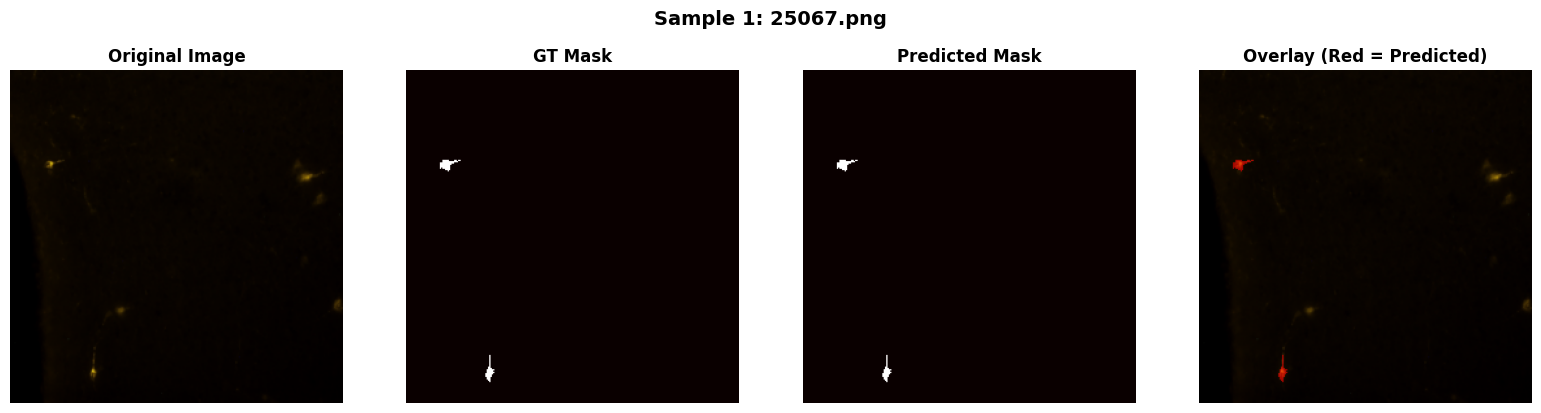

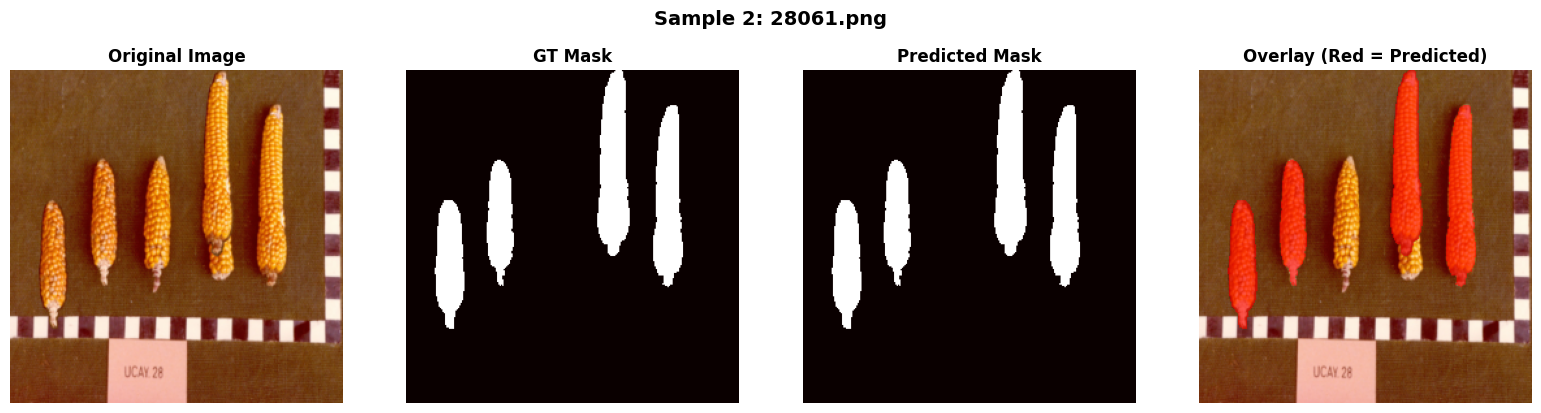

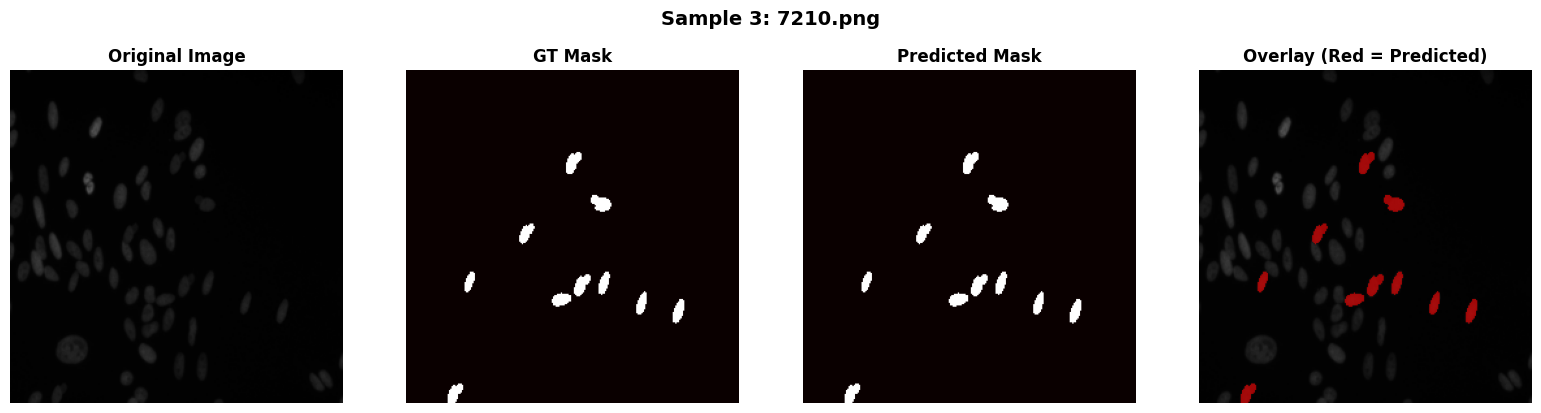

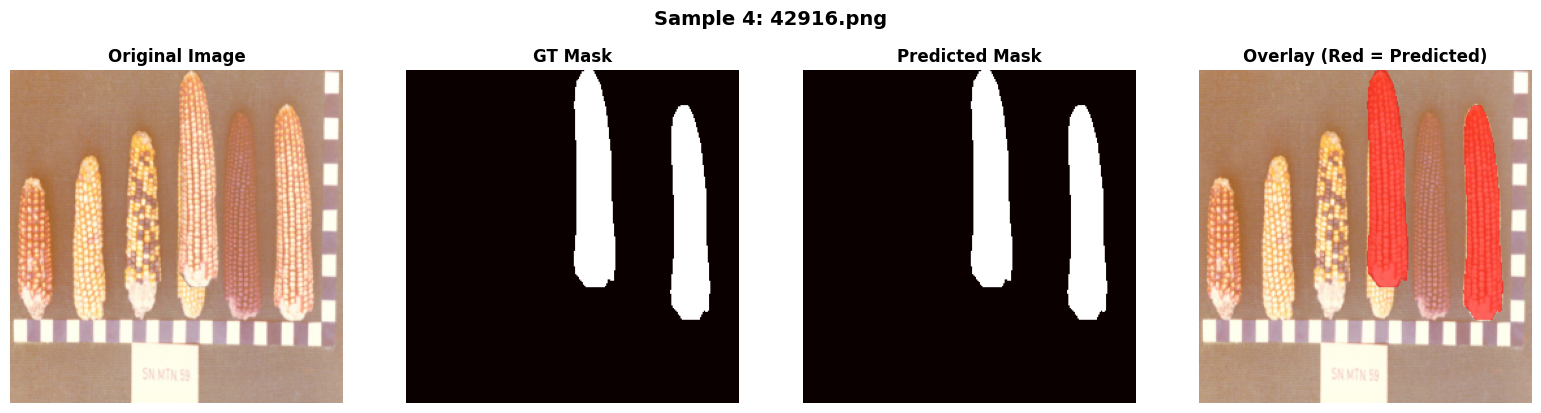

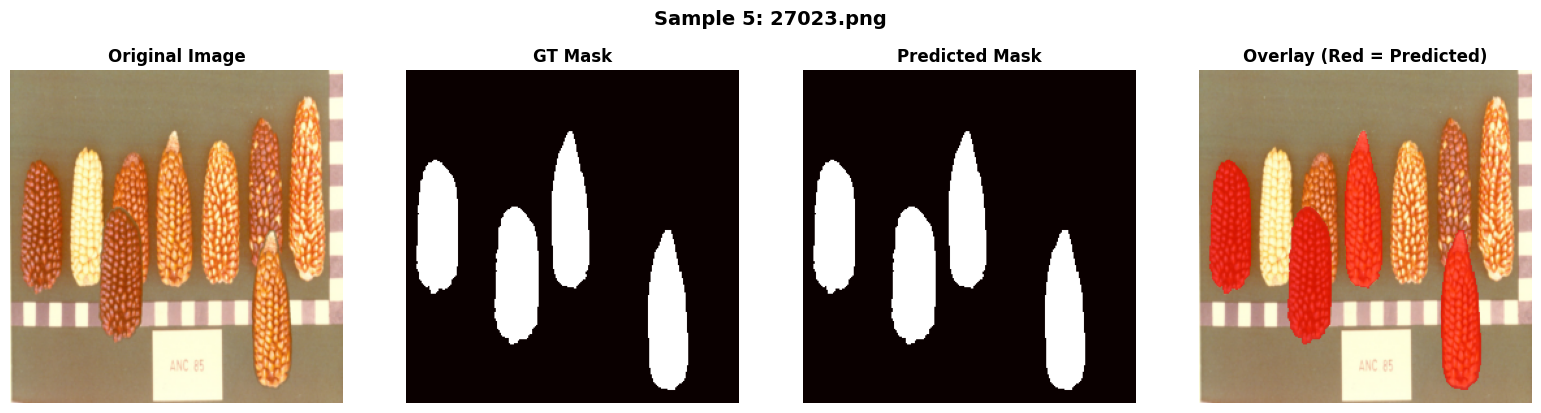

In [13]:
# Visualize 5 random samples from the dataloader
print("="*70)
print("VISUALIZING RANDOM SAMPLES FROM DATALOADER")
print("="*70)

# Get a random batch from the dataloader (shuffle=True ensures randomness)
batch = next(iter(train_loader))

images = batch['image']  # (B, 1, H, W)
masks = batch['mask']     # (B, 1, H, W)
paths = batch['path']     # List of paths

# Pick random images from this batch
num_samples = min(5, images.size(0))
random_indices = random.sample(range(images.size(0)), num_samples)

print(f"Selected a random batch with {images.size(0)} images")
print(f"Picked {num_samples} random samples from this batch")
print()

# Display each sample
for idx, i in enumerate(random_indices, 1):
    img_path = Path(paths[i]).name
    mask_sum = masks[i].sum().item()
    has_forgery = mask_sum > 0
    
    print(f"Sample {idx}/{num_samples}: {img_path}")
    print(f"  Has forgery: {has_forgery} (Mask pixels: {mask_sum:.0f})")
    
    # Use display_prediction_sequence with same mask for GT and pred (since we're just visualizing data)
    display_prediction_sequence(
        images[i],
        masks[i],
        masks[i],  # Use same mask for both GT and pred since we're just showing the data
        title=f"Sample {idx}: {img_path}",
        alpha=0.6
    )
    print()

print("="*70)


In [14]:
# Initialize model (uses MODEL_CONFIG defaults)
model = UNet3Plus().to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Optimizer (uses OPTIMIZER_CONFIG and TRAIN_CONFIG)
if OPTIMIZER_CONFIG['optimizer'] == 'Adam':
    optimizer = optim.Adam(
        model.parameters(), 
        lr=TRAIN_CONFIG['learning_rate'],
        weight_decay=OPTIMIZER_CONFIG['weight_decay'],
        betas=OPTIMIZER_CONFIG['betas']
    )
elif OPTIMIZER_CONFIG['optimizer'] == 'SGD':
    optimizer = optim.SGD(
        model.parameters(),
        lr=TRAIN_CONFIG['learning_rate'],
        weight_decay=OPTIMIZER_CONFIG['weight_decay'],
        momentum=0.9
    )
else:
    optimizer = optim.Adam(model.parameters(), lr=TRAIN_CONFIG['learning_rate'])

# Early stopping (uses TRAIN_CONFIG)
class EarlyStopping:
    def __init__(self, patience=None):
        if patience is None:
            patience = TRAIN_CONFIG['early_stopping_patience']
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), os.path.join(MODEL_SAVE_PATH, 'best_model.pth'))
        self.val_loss_min = val_loss

early_stopping = EarlyStopping()  # Uses TRAIN_CONFIG['early_stopping_patience']


Total parameters: 5,999,425
Trainable parameters: 5,999,425


In [15]:
# Training Loop
history = {
    'train_loss': [],
    'val_loss': [],
    'train_dice': [],
    'val_dice': [],
    'train_iou': [],
    'val_iou': []
}

# Track best validation dice for display (
best_val_dice = 0.0

print("="*70)
print("STARTING TRAINING")
print("="*70)
print(f"Model: UNet3Plus")
print(f"Device: {device}")
print(f"Epochs: {TRAIN_CONFIG['epochs']} | Batch Size: {TRAIN_CONFIG['batch_size']} | Learning Rate: {TRAIN_CONFIG['learning_rate']}")
print(f"Train samples: {len(train_dataset)} | Val samples: {len(val_dataset)}")
print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)}")
print("="*70)
print()

start_time = time()
epoch_start_time = time()

for epoch in range(TRAIN_CONFIG['epochs']):
    epoch_start_time = time()
    
    # At epoch 5 (0-indexed: epoch 4), switch to include authentic images
    if epoch == DATASET_CONFIG['skip_authentic_epochs']:
        print("\n" + "="*70)
        print(f"EPOCH {DATASET_CONFIG['skip_authentic_epochs']}: Switching to full dataset (including authentic images)")
        print("="*70)
        
        # Recreate dataset with skip_authentic=False
        full_dataset = ForgeryDataset(
            image_paths=all_train_images,
            mask_paths=all_train_masks,
            image_size=None,  # Uses DATASET_CONFIG['image_size']
            is_train=True,
            skip_authentic=False  # Now include all images
        )
        
        # Re-split dataset
        val_size = int(len(full_dataset) * TRAIN_CONFIG['val_split'])
        train_size = len(full_dataset) - val_size
        train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
        val_dataset.dataset.is_train = False
        
        # Recreate data loaders (uses TRAIN_CONFIG and DATASET_CONFIG)
        train_loader = DataLoader(
            train_dataset,
            batch_size=TRAIN_CONFIG['batch_size'],
            shuffle=True,
            num_workers=DATASET_CONFIG['num_workers'],
            pin_memory=DATASET_CONFIG['pin_memory'],
            prefetch_factor=DATASET_CONFIG['prefetch_factor'] if DATASET_CONFIG['num_workers'] > 0 else None
        )
        
        val_loader = DataLoader(
            val_dataset,
            batch_size=TRAIN_CONFIG['batch_size'],
            shuffle=False,
            num_workers=DATASET_CONFIG['num_workers'],
            pin_memory=DATASET_CONFIG['pin_memory'],
            prefetch_factor=DATASET_CONFIG['prefetch_factor'] if DATASET_CONFIG['num_workers'] > 0 else None
        )
        
        print(f"New train samples: {len(train_dataset)} | New val samples: {len(val_dataset)}")
        print(f"New train batches: {len(train_loader)} | New val batches: {len(val_loader)}")
        print("="*70 + "\n")
    
    # Training phase
    model.train()
    train_loss = 0.0
    train_dice = 0.0
    train_iou = 0.0
    
    # Debug: Check tensor shapes on first batch of first epoch
    if epoch == 0:
        first_batch = next(iter(train_loader))
        images_debug = first_batch['image'].to(device)
        masks_debug = first_batch['mask'].to(device)
        print(f"DEBUG: Image shape: {images_debug.shape}, Mask shape: {masks_debug.shape}")
        print(f"DEBUG: Image range: [{images_debug.min():.3f}, {images_debug.max():.3f}]")
        print(f"DEBUG: Mask range: [{masks_debug.min():.3f}, {masks_debug.max():.3f}]")
        print()
    
    # Training loop with tqdm
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{TRAIN_CONFIG['epochs']} [Train]", 
                      ncols=100, leave=False)
    
    for batch_idx, batch in enumerate(train_pbar):
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = combined_loss(outputs, masks)  # Uses LOSS_CONFIG defaults
        
        # Debug: Check for NaN/Inf
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"\nERROR: Invalid loss detected at batch {batch_idx}: {loss.item()}")
            break
        
        loss.backward()
        
        # Debug: Check gradients on first batch of first epoch
        if batch_idx == 0 and epoch == 0:
            total_grad_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    total_grad_norm += p.grad.data.norm(2).item()
            print(f"DEBUG: Gradient norm: {total_grad_norm:.4f}\n")
        
        optimizer.step()
        
        train_loss += loss.item()
        
        # Calculate loss and IoU
        with torch.no_grad():
            pred_binary = (outputs > 0.5).float()
            dice = dice_coefficient_torch(pred_binary, masks)
            iou = iou_score(pred_binary, masks)
            train_dice += dice
            train_iou += iou
        
        # Update progress bar
        avg_loss = train_loss / (batch_idx + 1)
        avg_dice = train_dice / (batch_idx + 1)
        avg_iou = train_iou / (batch_idx + 1)
        train_pbar.set_postfix({
            'Loss': f'{avg_loss:.4f}',
            'Dice': f'{avg_dice:.4f}',
            'IoU': f'{avg_iou:.4f}'
        })
    
    train_loss /= len(train_loader)
    train_dice /= len(train_loader)
    train_iou /= len(train_loader)
    train_time = time() - epoch_start_time
    
    # Validation phase with tqdm
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    val_iou = 0.0
    
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{TRAIN_CONFIG['epochs']} [Val]", 
                    ncols=100, leave=False)
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_pbar):
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            
            outputs = model(images)
            loss = combined_loss(outputs, masks)  # Uses LOSS_CONFIG defaults
            val_loss += loss.item()
            
            pred_binary = (outputs > 0.5).float()
            dice = dice_coefficient_torch(pred_binary, masks)
            val_dice += dice
            val_iou += iou_score(pred_binary, masks)
            
            # Update progress bar
            avg_loss = val_loss / (batch_idx + 1)
            avg_dice = val_dice / (batch_idx + 1)
            avg_iou = val_iou / (batch_idx + 1)
            val_pbar.set_postfix({
                'Loss': f'{avg_loss:.4f}',
                'Dice': f'{avg_dice:.4f}',
                'IoU': f'{avg_iou:.4f}'
            })
    
    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    val_iou /= len(val_loader)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_dice'].append(train_dice)
    history['val_dice'].append(val_dice)
    history['train_iou'].append(train_iou)
    history['val_iou'].append(val_iou)
    
    # Print epoch results
    print("-"*70)
    print(f"Epoch {epoch+1}/{TRAIN_CONFIG['epochs']} Results:")
    print(f"  Train - Loss: {train_loss:.4f} | Dice: {train_dice:.4f} | IoU: {train_iou:.4f}")
    print(f"  Val   - Loss: {val_loss:.4f} | Dice: {val_dice:.4f} | IoU: {val_iou:.4f}")
    print(f"  Time: {train_time:.2f}s")
    
    # Visualize 4 random samples from a random batch
    model.eval()
    with torch.no_grad():
        os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
        
        # Get a random batch
        batch = next(iter(train_loader))
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)
        paths = batch['path']
        
        # Get predictions
        outputs = model(images)
        pred_binary = (outputs > 0.5).float()
        
        # Select 4 random indices from the batch
        batch_size = images.size(0)
        num_samples = min(4, batch_size)
        random_indices = random.sample(range(batch_size), num_samples)
        
        print(f"\n  Visualizing {num_samples} random samples from batch:")
        
        for row_idx, i in enumerate(random_indices):
            # Handle RGB images (3, H, W) or grayscale (1, H, W)
            if images[i].shape[0] == 3:
                img_np = images[i].cpu().numpy().transpose(1, 2, 0)  # (H, W, 3)
            else:
                img_np = images[i, 0].cpu().numpy()  # (H, W)
            mask_np = masks[i, 0].cpu().numpy()
            pred_np = pred_binary[i, 0].cpu().numpy()
            img_path = Path(paths[i]).name
            img_stem = Path(paths[i]).stem
            
            # Calculate metrics
            dice = dice_coefficient(pred_np, mask_np)
            iou = iou_score(torch.tensor(pred_np), torch.tensor(mask_np))
            
            print(f"    Sample {row_idx+1}: {img_path} | Dice: {dice:.3f} | IoU: {iou:.3f}")
            
            # Use the visualization function
            fig_seq = display_prediction_sequence(
                img_np,
                mask_np,
                pred_np,
                title=f"Epoch {epoch+1} - Sample {row_idx+1}: {img_path} (Dice: {dice:.3f}, IoU: {iou:.3f})",
                alpha=0.6
            )
            
            # Save the figure
            save_path = os.path.join(MODEL_SAVE_PATH, f'epoch_{epoch+1:03d}_sample_{row_idx+1}_{img_stem}.png')
            fig_seq.savefig(save_path, dpi=150, bbox_inches='tight')
            plt.close(fig_seq)
    
    model.train()  # Set back to training mode
    
    # Save checkpoint (overwrite each epoch)
    checkpoint_path = os.path.join(MODEL_SAVE_PATH, 'checkpoint.pth')
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_dice': val_dice,
        'val_iou': val_iou,
        'train_loss': train_loss,
        'val_loss': val_loss,
    }, checkpoint_path)
    print(f"  ✓ Checkpoint saved: {checkpoint_path}")
    
    # Early stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print(f"  ⚠ Early stopping triggered at epoch {epoch+1}")
        print(f"  Best validation loss: {early_stopping.val_loss_min:.4f}")
        break
    
    print()

training_time = time() - start_time
print("="*70)
print("TRAINING COMPLETED")
print("="*70)
print(f"Total time: {training_time/60:.2f} minutes ({training_time:.2f} seconds)")
print(f"Total epochs: {len(history['train_loss'])}")
print(f"Best validation Dice: {max(history['val_dice']):.4f}")
print(f"Final train loss: {history['train_loss'][-1]:.4f}")
print(f"Final val loss: {history['val_loss'][-1]:.4f}")
print(f"Final train dice: {history['train_dice'][-1]:.4f}")
print(f"Final val dice: {history['val_dice'][-1]:.4f}")
print(f"Final train IoU: {history['train_iou'][-1]:.4f}")
print(f"Final val IoU: {history['val_iou'][-1]:.4f}")
print("="*70)


STARTING TRAINING
Model: UNet3Plus
Device: cuda
Epochs: 20 | Batch Size: 16 | Learning Rate: 0.0001
Train samples: 2339 | Val samples: 412
Train batches: 147 | Val batches: 26

DEBUG: Image shape: torch.Size([16, 3, 256, 256]), Mask shape: torch.Size([16, 1, 256, 256])
DEBUG: Image range: [0.000, 1.000]
DEBUG: Mask range: [0.000, 1.000]



Epoch 1/20 [Train]:   1%|     | 1/147 [00:01<03:49,  1.57s/it, Loss=5.3485, Dice=0.1266, IoU=0.0676]

DEBUG: Gradient norm: 32.0659



----------------------------------------------------------------------
Epoch 1/20 Results:
  Train - Loss: 1.6115 | Dice: 0.2527 | IoU: 0.1480
  Val   - Loss: 1.3065 | Dice: 0.3472 | IoU: 0.2133
  Time: 128.79s

  Visualizing 4 random samples from batch:
    Sample 1: 43285.png | Dice: 0.313 | IoU: 0.185
    Sample 2: 59969.png | Dice: 0.554 | IoU: 0.383
    Sample 3: 54950.png | Dice: 0.001 | IoU: 0.000
    Sample 4: 16614.png | Dice: 0.004 | IoU: 0.000
  ✓ Checkpoint saved: ./saved_models\checkpoint.pth



----------------------------------------------------------------------
Epoch 2/20 Results:
  Train - Loss: 0.8298 | Dice: 0.3452 | IoU: 0.2124
  Val   - Loss: 0.8955 | Dice: 0.3866 | IoU: 0.2436
  Time: 128.31s

  Visualizing 4 random samples from batch:
    Sample 1: 44157.png | Dice: 0.004 | IoU: 0.000
    Sample 2: 64360.png | Dice: 0.002 | IoU: 0.000
    Sample 3: 57324.png | Dice: 0.485 | IoU: 0.320
    Sample 4: 6999.png | Dice: 0.007 | IoU: 0.002
  ✓ Checkpoint saved: ./saved_models\checkpoint.pth



----------------------------------------------------------------------
Epoch 3/20 Results:
  Train - Loss: 0.7489 | Dice: 0.3606 | IoU: 0.2238
  Val   - Loss: 0.6630 | Dice: 0.3968 | IoU: 0.2511
  Time: 130.35s

  Visualizing 4 random samples from batch:
    Sample 1: 9720.png | Dice: 0.000 | IoU: 0.000
    Sample 2: 13665.png | Dice: 0.024 | IoU: 0.011
    Sample 3: 2896.png | Dice: 0.004 | IoU: 0.000
    Sample 4: 17583.png | Dice: 0.868 | IoU: 0.767
  ✓ Checkpoint saved: ./saved_models\checkpoint.pth



----------------------------------------------------------------------
Epoch 4/20 Results:
  Train - Loss: 0.6329 | Dice: 0.3823 | IoU: 0.2412
  Val   - Loss: 0.8534 | Dice: 0.4083 | IoU: 0.2604
  Time: 124.48s

  Visualizing 4 random samples from batch:
    Sample 1: 41255.png | Dice: 0.002 | IoU: 0.000
    Sample 2: 35670.png | Dice: 0.000 | IoU: 0.000
    Sample 3: 11785.png | Dice: 0.000 | IoU: 0.000
    Sample 4: 9299.png | Dice: 0.001 | IoU: 0.000
  ✓ Checkpoint saved: ./saved_models\checkpoint.pth



----------------------------------------------------------------------
Epoch 5/20 Results:
  Train - Loss: 0.6181 | Dice: 0.3810 | IoU: 0.2409
  Val   - Loss: 0.6533 | Dice: 0.4050 | IoU: 0.2575
  Time: 123.51s

  Visualizing 4 random samples from batch:
    Sample 1: 7127.png | Dice: 0.493 | IoU: 0.328
    Sample 2: 35471.png | Dice: 0.012 | IoU: 0.000
    Sample 3: 51718.png | Dice: 0.000 | IoU: 0.000
    Sample 4: 1270.png | Dice: 0.005 | IoU: 0.000
  ✓ Checkpoint saved: ./saved_models\checkpoint.pth



KeyboardInterrupt: 

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0].plot(history['val_loss'], label='Val Loss', color='red')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history['train_dice'], label='Train Dice', color='blue')
axes[1].plot(history['val_dice'], label='Val Dice', color='red')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice Coefficient')
axes[1].set_title('Training and Validation Dice Score')
axes[1].legend()
axes[1].grid(True)

axes[2].plot(history['train_iou'], label='Train IoU', color='blue')
axes[2].plot(history['val_iou'], label='Val IoU', color='red')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('IoU Score')
axes[2].set_title('Training and Validation IoU Score')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_SAVE_PATH, 'training_history.png'), dpi=150)
plt.show()


In [ ]:
# Load latest checkpoint and test on validation set
checkpoint = torch.load(os.path.join(MODEL_SAVE_PATH, 'checkpoint.pth'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Evaluate on validation set
val_dice_scores = []
val_iou_scores = []

with torch.no_grad():
    for batch in val_loader:
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)
        
        outputs = model(images)
        pred_binary = (outputs > 0.5).float()
        
        # Calculate metrics per sample
        for i in range(images.size(0)):
            pred_np = pred_binary[i, 0].cpu().numpy()
            mask_np = masks[i, 0].cpu().numpy()
            
            dice = dice_coefficient(pred_np, mask_np)
            iou = iou_score(torch.tensor(pred_np), torch.tensor(mask_np))
            
            val_dice_scores.append(dice)
            val_iou_scores.append(iou)

print(f"Validation Dice Score: {np.mean(val_dice_scores):.4f} ± {np.std(val_dice_scores):.4f}")
print(f"Validation IoU Score: {np.mean(val_iou_scores):.4f} ± {np.std(val_iou_scores):.4f}")


In [ ]:
# Visualize predictions on validation samples
def visualize_predictions(model, val_loader, device, num_samples=8):
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    
    sample_count = 0
    with torch.no_grad():
        for batch in val_loader:
            if sample_count >= num_samples:
                break
            
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            
            outputs = model(images)
            pred_binary = (outputs > 0.5).float()
            
            for i in range(min(images.size(0), num_samples - sample_count)):
                # Handle RGB images (3, H, W) or grayscale (1, H, W)
                if images[i].shape[0] == 3:
                    img = images[i].cpu().numpy().transpose(1, 2, 0)  # (H, W, 3)
                else:
                    img = images[i, 0].cpu().numpy()  # (H, W)
                mask = masks[i, 0].cpu().numpy()
                pred = pred_binary[i, 0].cpu().numpy()
                
                # Original image
                if img.ndim == 2:
                    axes[sample_count, 0].imshow(img, cmap='gray')
                else:
                    axes[sample_count, 0].imshow(img)
                axes[sample_count, 0].set_title('Original Image')
                axes[sample_count, 0].axis('off')
                
                # Ground truth mask
                axes[sample_count, 1].imshow(mask, cmap='gray')
                axes[sample_count, 1].set_title('Ground Truth Mask')
                axes[sample_count, 1].axis('off')
                
                # Predicted mask
                axes[sample_count, 2].imshow(pred, cmap='gray')
                
                # Calculate metrics for this sample
                dice = dice_coefficient(pred, mask)
                iou = iou_score(torch.tensor(pred), torch.tensor(mask))
                axes[sample_count, 2].set_title(f'Predicted Mask\\nDice: {dice:.3f}, IoU: {iou:.3f}')
                axes[sample_count, 2].axis('off')
                
                sample_count += 1
                if sample_count >= num_samples:
                    break
    
    plt.tight_layout()
    plt.savefig(os.path.join(MODEL_SAVE_PATH, 'validation_predictions.png'), dpi=150, bbox_inches='tight')
    plt.show()

visualize_predictions(model, val_loader, device, num_samples=8)


In [ ]:
# Inference on test images
test_images = glob.glob(os.path.join(TEST_IMAGES_DIR, '*.png'))
print(f"Test images found: {len(test_images)}")

if len(test_images) > 0:
    # Create test dataset
    test_dataset = ForgeryDataset(
        image_paths=test_images,
        mask_paths=None,
        image_size=None,  # Uses DATASET_CONFIG['image_size']
        is_train=False
    )
    
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    # Create output directory for masks
    output_dir = './output_masks'
    os.makedirs(output_dir, exist_ok=True)
    
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            images = batch['image'].to(device)
            img_path = batch['path'][0]
            
            # Get prediction
            outputs = model(images)
            pred_binary = (outputs > 0.5).float()
            
            # Convert to numpy
            pred_mask = pred_binary[0, 0].cpu().numpy()
            
            # Save mask
            img_stem = Path(img_path).stem
            mask_path = os.path.join(output_dir, f'{img_stem}_mask.png')
            
            # Save as PNG
            pred_mask_uint8 = (pred_mask * 255).astype(np.uint8)
            Image.fromarray(pred_mask_uint8, mode='L').save(mask_path)
            
            # Also save as numpy array
            np.save(os.path.join(output_dir, f'{img_stem}_mask.npy'), pred_mask)
            
            print(f"Saved mask for {img_stem}: {mask_path}")
            
            # Visualize
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            
            # Handle RGB images (3, H, W) or grayscale (1, H, W)
            if images[0].shape[0] == 3:
                img_np = images[0].cpu().numpy().transpose(1, 2, 0)  # (H, W, 3)
            else:
                img_np = images[0, 0].cpu().numpy()  # (H, W)
            
            if img_np.ndim == 2:
                axes[0].imshow(img_np, cmap='gray')
            else:
                axes[0].imshow(img_np)
            axes[0].set_title(f'Test Image: {img_stem}')
            axes[0].axis('off')
            
            axes[1].imshow(pred_mask, cmap='gray')
            axes[1].set_title('Detected Copy-Move Mask')
            axes[1].axis('off')
            
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, f'{img_stem}_result.png'), dpi=150, bbox_inches='tight')
            plt.show()
    
    print(f"\\nAll test masks saved to {output_dir}")
else:
    print("No test images found.")
